In [156]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

<img src="images/hw_boston2.jpg">

# Добро пожаловать!

Зайдите на http://www.kaggle.com и зарегистрируйтесь. 

Далее вам нужен датасет по этой ссылке: https://www.kaggle.com/c/ghouls-goblins-and-ghosts-boo . И __train__, и __test__, и __sample_submission__. 

Скачайте его и положите рядом с тетрадью, как вам удобнее.

In [157]:
train, test = pd.read_csv('data/GGG/train.csv'), pd.read_csv('data/GGG/test.csv')

In [158]:
train.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [159]:
X = train.drop(['id', 'type'], axis=1)
y = train['type']

# К делу!

## Выполним необходимое кодирование

В этот раз я помогу немного :)

### Метки классов

In [160]:
from sklearn.preprocessing import LabelEncoder

In [161]:
answers_encoder = LabelEncoder()
y = answers_encoder.fit_transform(y)

In [162]:
y[:5] # вместо строк получились метки классов

array([1, 2, 1, 1, 0])

In [163]:
answers_encoder.classes_ # - здесь наши классы все еще лежат

array(['Ghost', 'Ghoul', 'Goblin'], dtype=object)

Используйте метод __inverse_transform__, чтобы превратить предсказания алгоритмов (числа) обратно в строки:

In [164]:
from sklearn.linear_model import LogisticRegression

In [167]:
answers_encoder.inverse_transform(
    # сюда массив с предсказаниями
)

```python
# типа того:
clf = LogisticRegression()
clf.fit(X_train, y_train);
predicts = clf.predict(X_test)
strings = answers_encoder.inverse_transform(predicts) # <-- !
```

### Теперь все признаки

У нас встретился признак цвета - __color__ - закодируем его так, как я сделал ниже. В этот раз.

In [168]:
def onehot_encode(df_train, df_test, column):
    from sklearn.preprocessing import LabelBinarizer
    
    cs = df_train.select_dtypes(include=['O']).columns.values
    if column not in cs:
        return (df_train, df_test, None)

    rest = [x for x in df_train.columns.values if x != column]

    lb = LabelBinarizer()
    train_data = lb.fit_transform(df_train[column])
    test_data = lb.transform(df_test[column])
    new_col_names = ['%s_%s' % (column, x) for x in lb.classes_]

    if len(new_col_names) != train_data.shape[1]:
        new_col_names = new_col_names[::-1][:train_data.shape[1]]

    new_train = pd.concat((df_train.drop([column], axis=1), pd.DataFrame(data=train_data, columns=new_col_names)), axis=1)
    new_test = pd.concat((df_test.drop([column], axis=1), pd.DataFrame(data=test_data, columns=new_col_names)), axis=1)
    return (new_train, new_test, lb)

In [169]:
X.head(2)

,bone_length,rotting_flesh,hair_length,has_soul,color
0,0.354512,0.350839,0.465761,0.781142,clear
1,0.575560,0.425868,0.531401,0.439899,green


In [170]:
X, test, lb = onehot_encode(X, test, 'color')

In [171]:
X.head(2)

,bone_length,rotting_flesh,hair_length,has_soul,color_black,color_blood,color_blue,color_clear,color_green,color_white
0,0.354512,0.350839,0.465761,0.781142,0,0,0,1,0,0
1,0.575560,0.425868,0.531401,0.439899,0,0,0,0,1,0


In [172]:
test.head(2) 

,id,bone_length,rotting_flesh,hair_length,has_soul,color_black,color_blood,color_blue,color_clear,color_green,color_white
0,3,0.471774,0.387937,0.706087,0.698537,1,0,0,0,0,0
1,6,0.427332,0.645024,0.565558,0.451462,0,0,0,0,0,1


Мы превратили все признаки в числовой вид, и с этим можно работать!

# Классификация

Зафиксируем генератор случайных чисел, чтобы у всех вас получались одни и те же значения:

In [173]:
SEED = 1234
np.random.seed = SEED

Сформируем отложенную выборку:

In [174]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.85, random_state=SEED) # <- проверяйте у себя:
                                                                                        # если что-то принимает random_state 
                                                                                        # параметром, передавайте ему SEED

In [175]:
from sklearn.model_selection import cross_val_score

<div class="panel panel-info" style="margin: 50px 0 0 0">
    <div class="panel-heading">
        <h3 class="panel-title">Задача 1.</h3> 
    </div>
    <div class="panel">
        Обучите <b>LogisticRegression</b> (конечно же, с лучшими найденными параметрами с помощью GridSearch) из пакета <b>sklearn.linear_model</b>. Проверьте его качество.
    </div>
</div>

In [206]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

In [207]:
logreg = LogisticRegressionCV(cv=10)
logreg.fit(X, y);

In [208]:
scores = cross_val_score(LogisticRegressionCV(), X, y, scoring='accuracy', cv=10)
print('Точность: %s +/- %s' % (scores.mean(), 2*scores.std()))

Точность: 0.711134028766 +/- 0.157824577213


<div class="panel panel-info" style="margin: 50px 0 0 0">
    <div class="panel-heading">
        <h3 class="panel-title">Задача 2.</h3> 
    </div>
    <div class="panel">
        Время дать шанс <b>KNearestNeighbors</b> из пакета <b>sklearn.neighbors</b> и <b>SVC</b> из пакета <b>sklearn.svm</b>. Сделайте то же, что и сделали выше.
    </div>
</div>

In [209]:
from sklearn.grid_search import GridSearchCV

In [210]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [211]:
knn = GridSearchCV(KNeighborsClassifier(), {
    'n_neighbors': [1,2,4,8,16,32]
}, cv=10)
knn.fit(X, y);

In [212]:
knn.best_score_

0.6684636118598383

In [213]:
scores = cross_val_score(knn.best_estimator_, X, y, scoring='accuracy', cv=10)
print('Точность: %s +/- %s' % (scores.mean(), 2*scores.std()))

Точность: 0.66763722369 +/- 0.182518469389


&nbsp;

In [214]:
svc = GridSearchCV(SVC(), {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'class_weight': ['balanced', None],
    'gamma': ['auto', 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}, cv=10)
svc.fit(X, y);

In [215]:
svc.best_score_

0.7331536388140162

In [216]:
scores = cross_val_score(svc.best_estimator_, X, y, scoring='accuracy', cv=10)
print('Точность: %s +/- %s' % (scores.mean(), 2*scores.std()))

Точность: 0.733397796293 +/- 0.147836188276


<div class="panel panel-info" style="margin: 50px 0 0 0">
    <div class="panel-heading">
        <h3 class="panel-title">Задача 3.</h3> 
    </div>
    <div class="panel">
        Проанализируйте лучшие классификаторы:
        <ol>
            <li> Распечатайте отчет о классификации (<b>classification report</b> из <b>sklearn.metrics</b>)
            <li> Постройте ROC-AUC-кривую (с помощью scikit-plot)
            <li> Постройте матрицу перепутывания классов (с помощью scikit-plot)
        </ol>
    </div>
</div>

In [235]:
from sklearn.metrics import classification_report
from scikitplot import classifier_factory

In [218]:
lr_best = logreg
knn_best = knn.best_estimator_
svc_best = svc.best_estimator_

In [219]:
lr_best.fit(X_train, y_train);
knn_best.fit(X_train, y_train);
svc_best.fit(X_train, y_train);

### Confusion matrix

In [196]:
print('\t=====\tLogistic Regression\t=====\t\n')
print(classification_report(y_validation, lr_best.predict(X_validation)))

	=====	Logistic Regression	=====	

             precision    recall  f1-score   support

          0       0.82      0.93      0.87        15
          1       0.65      0.89      0.76        19
          2       0.77      0.45      0.57        22

avg / total       0.74      0.73      0.72        56



In [197]:
print('\t=====\tK Nearest Neighbors\t=====\t\n')
print(classification_report(y_validation, knn_best.predict(X_validation)))

	=====	K Nearest Neighbors	=====	

             precision    recall  f1-score   support

          0       0.81      0.87      0.84        15
          1       0.56      0.74      0.64        19
          2       0.53      0.36      0.43        22

avg / total       0.62      0.62      0.61        56



In [198]:
print('\t=====\tSVC\t=====\t\n')
print(classification_report(y_validation, svc_best.predict(X_validation)))

	=====	SVC	=====	

             precision    recall  f1-score   support

          0       0.81      0.87      0.84        15
          1       0.70      0.84      0.76        19
          2       0.71      0.55      0.62        22

avg / total       0.73      0.73      0.72        56



### ROC-AUC

In [220]:
classifier_factory(lr_best);
classifier_factory(knn_best);
classifier_factory(svc_best);

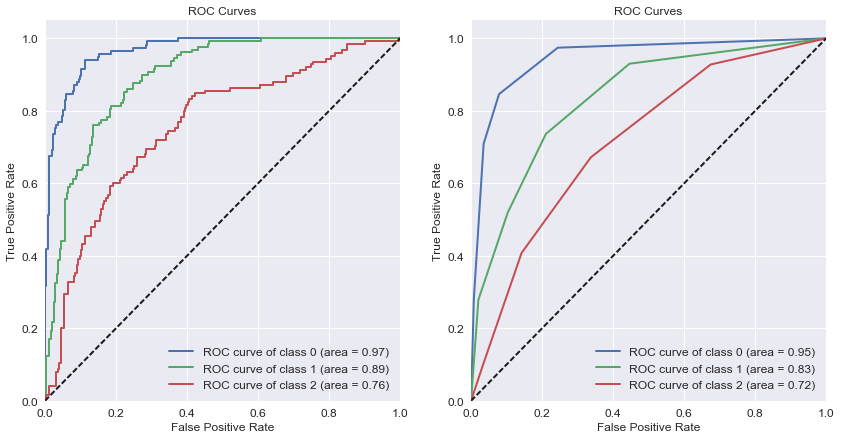

In [236]:
f, axs = plt.subplots(1, 2, figsize=(14, 7))
lr_best.plot_roc_curve(X.values, y, curves='each_class', title_fontsize='large', text_fontsize='large', ax=axs[0], cv=10);
knn_best.plot_roc_curve(X.values, y, curves='each_class', title_fontsize='large', text_fontsize='large', ax=axs[1], cv=10);

### Confusion matrix

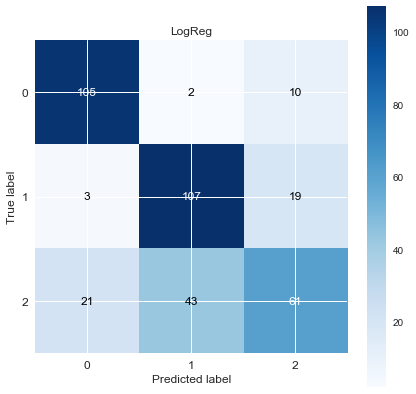

In [245]:
lr_best.plot_confusion_matrix(X.values, y, title='LogReg', title_fontsize='large', text_fontsize='large', cv=10, figsize=(7,7));

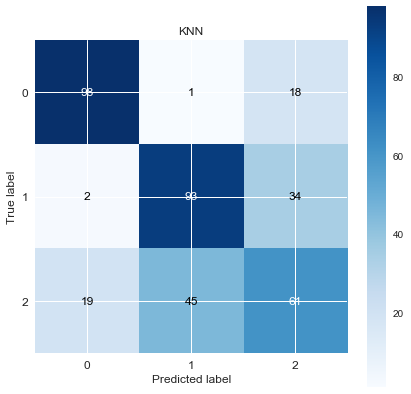

In [246]:
knn_best.plot_confusion_matrix(X.values, y, title='KNN', title_fontsize='large', text_fontsize='large', cv=10, figsize=(7,7));

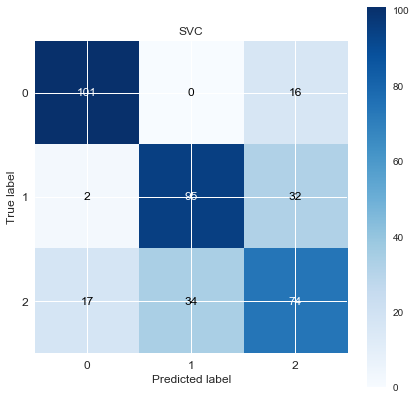

In [247]:
svc_best.plot_confusion_matrix(X.values, y, title='SVC', title_fontsize='large', text_fontsize='large', cv=10, figsize=(7,7));

<div class="panel panel-info" style="margin: 50px 0 0 0">
    <div class="panel-heading">
        <h3 class="panel-title">Задача 4.</h3> 
    </div>
    <div class="panel">
        Предскажите найденным вами лучшим алгоритмом тестовую (датафрейм <b>test</b>) выборку. Обратите внимание на <b>sample_submission</b> - формат отправки ответов. Сделайте так же, например.
        <br><br>
        Отошлите результаты на Kaggle в их проверяющую систему.
        <br><br>
        Расскажите о ваших результатах в Slack :)
    </div>
</div>

In [248]:
from sklearn.ensemble import VotingClassifier

In [257]:
clf = VotingClassifier([
    ('logreg', lr_best), 
    ('knn', knn_best), 
    ('svc', svc_best),
    ('svc2', SVC(C=100)),
    ('svc3', SVC(C=1000)),
])
clf.fit(X, y);

In [256]:
scores = cross_val_score(clf, X, y, scoring='accuracy', cv=10)
print('Точность: %s +/- %s' % (scores.mean(), 2*scores.std()))

Точность: 0.735787328682 +/- 0.108821484199


In [258]:
test.head(1)

,id,bone_length,rotting_flesh,hair_length,has_soul,color_black,color_blood,color_blue,color_clear,color_green,color_white
0,3,0.471774,0.387937,0.706087,0.698537,1,0,0,0,0,0


In [262]:
answers = clf.predict(test.drop(['id'], axis=1))
answers = answers_encoder.inverse_transform(answers)
ids = test.id

In [263]:
submission = pd.DataFrame(data={'id': ids, 'type': answers })

In [264]:
submission.head()

,id,type
0,3,Ghoul
1,6,Goblin
2,9,Ghoul
3,10,Ghost
4,13,Ghost


In [265]:
submission.to_csv('submission.csv', index=False)

С помощью кода ниже можно записать ваши предсказания в файл:

```python
answers = pd.DataFrame(data={'id': [1,2,3], 'type': ['Ghost','Goblin','Ghoul']})
answers.to_csv('submission.csv', index=False)
```

<img src="images/hw_boston3.jpg">